# pyWavelet Snow Radar Processor

In [1]:
#pyWavelet modules
from pyWavelet import snowradar, picklayers

#Python stdlib
import os
import datetime
import time

#Community packages
import numpy as np
import matplotlib.pyplot as plt

In [2]:
density_snow = 0.300 #Density of snow on sea ice; See Alexandrov et al., 2010, The Cryosphere
perm_snow = (1 + 0.51 * density_snow) ** 3  #Density to permitivity
n_snow = np.sqrt(perm_snow) #Permitivity to refractive index
c = 299792458 #Vacuum speed of light

In [3]:
#radar_file = "./data/sr/Data_20160419_04_010.mat"
radar_file = "./data/eureka/sr/Data_20160419_04_025.mat"
#radar_file = "E:/OIB/snowradar/CSARP_deconv/20170310_01/Data_20170310_01_088.mat"
#radar_file = "E:/OIB/snowradar/CSARP_deconv/Data_20160419_05_005.mat"

radar_dat = snowradar.OIB(radar_file, l_case='full')

In [4]:
radar_dat.extent

array([-86.76090247,  80.24690155, -86.75700935,  80.2915993 ])

Convert the radar's GPS time to UTC and account for leap seconds

In [5]:
example_date = datetime.datetime.utcfromtimestamp(radar_dat.time_utc[0])
print(example_date)

2016-04-19 13:16:56.683471


In [6]:
radar_sub = radar_dat.data_radar
#radar_1d_smooth = np.apply_along_axis(RadarWindow, 0, radar_sub, 5)
#radar_2d_smooth = signal.medfilt2d(radar_sub, kernel_size=5)

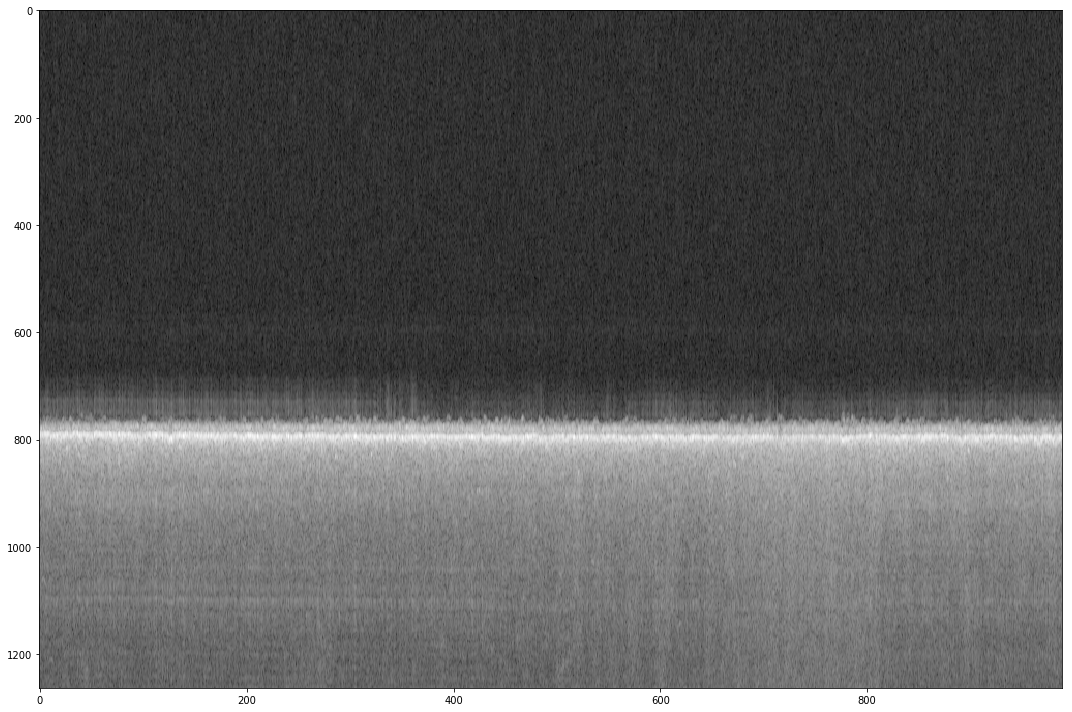

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(10 * np.log10(radar_sub), cmap="gist_gray")
ax.set_aspect('auto')
fig.tight_layout();

### Signals stuff

In [8]:
oversample_num = 1000
num_nyquist_ts = 100
nyquist_sf = 2*radar_dat.bandwidth
fs = nyquist_sf *oversample_num 
time_step = 1/fs 
max_time  = num_nyquist_ts*oversample_num*time_step
time_vect = np.arange(-max_time,max_time,time_step)

In [9]:
radar_dat.calcpulsewidth()
print(radar_dat.epw)
print(radar_dat.n2n)

0.07570516616161616
0.20186025505333335


### This applies the picklayer function to every trace
TODO: Multi thread and bake into snowradar class

In [10]:
l_as, l_si = np.apply_along_axis(
    picklayers.picklayers, 
    0, 
    radar_sub,
    radar_dat.n2n,
    radar_dat.dfr,
    n_snow
)

In [11]:
snow_depth = (l_si - l_as) * radar_dat.dfr / n_snow

# Retrieval output

Max along-track resolution
Mean depth (m): 0.2922192323955348
StDev of  depth (m): 0.056446262180806644

5-bin averaged along-track 
Mean snow depth (m): 0.29233124051104703
StDev of snow depth (m): 0.03887678456096163


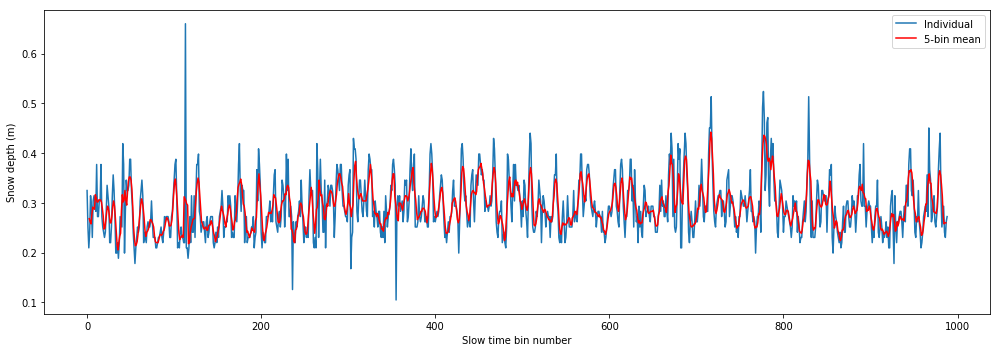

In [12]:
N = 5
snow_depth_rollin = np.convolve(snow_depth, np.ones((N,))/N, mode='valid')
estart = N/2
eend = len(snow_depth_rollin)+(N/2)
print("Max along-track resolution")
print("Mean depth (m):", np.mean(snow_depth))
print("StDev of  depth (m):", np.std(snow_depth))
print("\n5-bin averaged along-track ")
print("Mean snow depth (m):", np.mean(snow_depth_rollin))
print("StDev of snow depth (m):", np.std(snow_depth_rollin))

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(snow_depth)
#ax.plot(np.arange(0, len(snow_depth_rollin)),snow_depth_rollin, color='r')
ax.plot(np.arange(estart, eend),snow_depth_rollin, color='r')

#ax.plot(l_as, color='b')
ax.set_ylabel("Snow depth (m)")
ax.set_xlabel("Slow time bin number")
ax.legend(["Individual","5-bin mean"],loc="upper right")
fig.tight_layout();

(array([ 1.,  1.,  3., 13.,  6., 12., 16., 37., 27., 28., 36., 58., 38.,
        39., 41., 70., 51., 38., 43., 69., 36., 35., 34., 43., 21., 18.,
        24., 12., 24., 13., 23.,  4., 21.,  6., 11.,  4.,  6.,  6.,  5.,
         2.,  2.,  0.,  0.,  0.,  1.,  2.,  1.,  1.,  2.,  1.]),
 array([0.20542138, 0.21015865, 0.21489591, 0.21963318, 0.22437045,
        0.22910772, 0.23384499, 0.23858226, 0.24331953, 0.24805679,
        0.25279406, 0.25753133, 0.2622686 , 0.26700587, 0.27174314,
        0.27648041, 0.28121767, 0.28595494, 0.29069221, 0.29542948,
        0.30016675, 0.30490402, 0.30964128, 0.31437855, 0.31911582,
        0.32385309, 0.32859036, 0.33332763, 0.3380649 , 0.34280216,
        0.34753943, 0.3522767 , 0.35701397, 0.36175124, 0.36648851,
        0.37122578, 0.37596304, 0.38070031, 0.38543758, 0.39017485,
        0.39491212, 0.39964939, 0.40438665, 0.40912392, 0.41386119,
        0.41859846, 0.42333573, 0.428073  , 0.43281027, 0.43754753,
        0.4422848 ]),
 <a list of 50

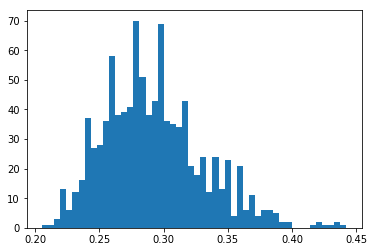

In [13]:
plt.hist(snow_depth_rollin, bins=50)

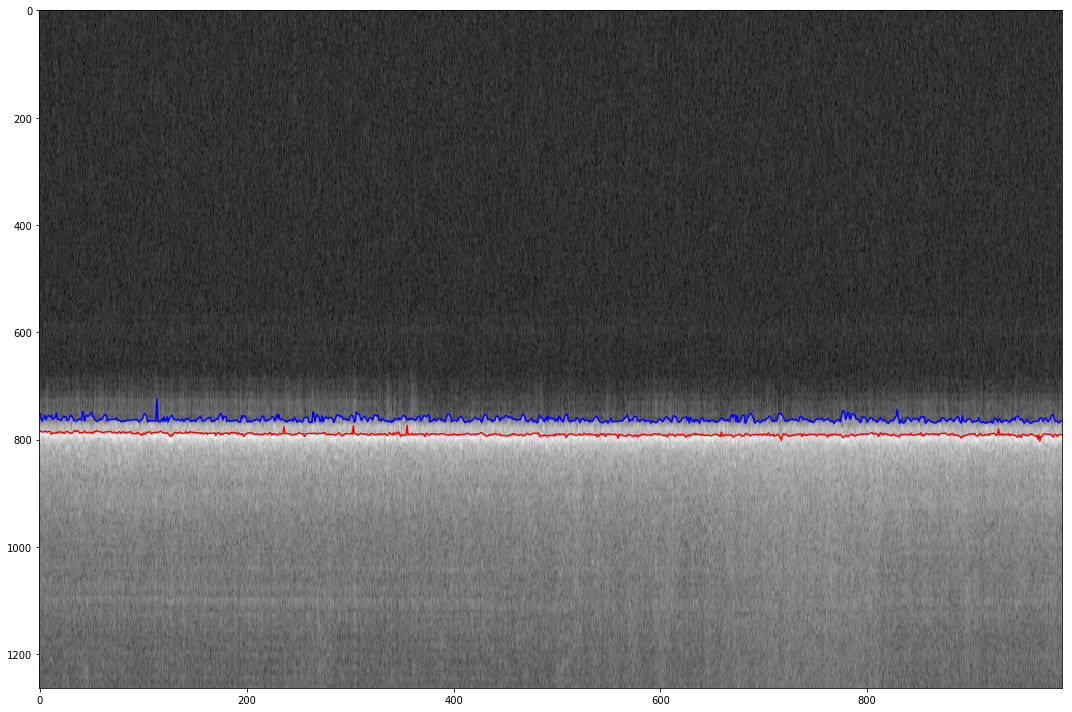

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(10 * np.log10(radar_sub), interpolation='nearest', cmap="gist_gray")
ax.plot(l_si, color='r')
ax.plot(l_as, color='b')
#ax.set_ylim([900, 600])
ax.set_aspect('auto')
fig.tight_layout();

297


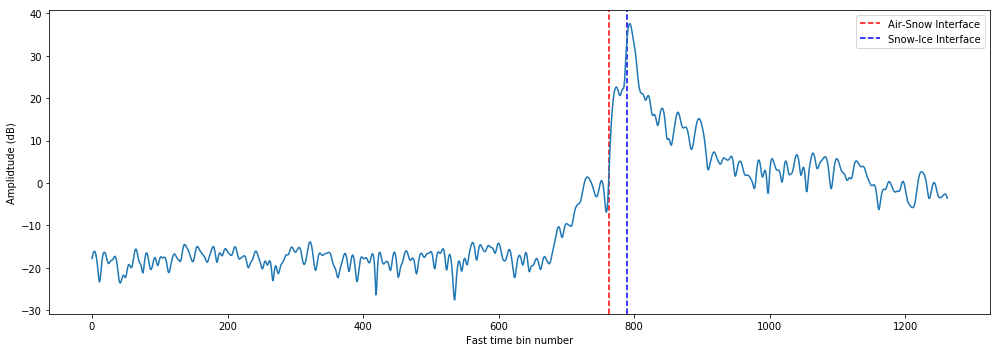

In [16]:
col_idx = np.random.randint(0, radar_sub.shape[1])
print(col_idx)
fig, ax = plt.subplots(figsize=(14,5))
#ax.plot(data_col)
ax.plot(10*np.log10(radar_sub[:,col_idx]), label=None)
#ax.plot(radar_sub[:,col_idx], label=None)

# Air-Snow picked interface
ax.vlines(l_as[col_idx], 0, 1, label='Air-Snow Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='r')
# Snow-Ice picked interface
ax.vlines(l_si[col_idx], 0, 1, label='Snow-Ice Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='b')
ax.set_xlabel("Fast time bin number")
ax.set_ylabel("Amplidtude (dB)")
ax.legend(loc="upper right")
#ax.set_xlim([ymin, ymax])
fig.tight_layout();